In [1]:
#If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

#In addition, uncomment and run the following code:
# !pip install pzflow

#Intro to pzflow

#This notebook demonstrates building a normalizing flow with pzflow to learn the joint probability distribution of some 2-D data.#

#You do not need to have any previous knowledge of normalizing flows to get started with pzflow, however if you are interested, here are some good sources:

#    Eric Jang's tutorial: part 1, part 2
#    Here is a comprehensive list of papers, blogs, videos, and packages
#    Two good intro papers using Coupling Layers: NICE, Real NVP
#    The paper on Neural Spline Couplings

import jax.numpy as np
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd

ModuleNotFoundError: No module named 'jax'

In [2]:
data_full = pd.read_csv("./DF034.csv")
data_full_other = pd.read_csv("./DF12.csv")
data_full = pd.concat([data_full, data_full_other], ignore_index=True)

In [3]:
data_full['logSFRtot'] = np.log10(data_full['totalStarFormationRate'])

In [4]:
data_full['logmass'] = np.log10(data_full['stellar_mass'])

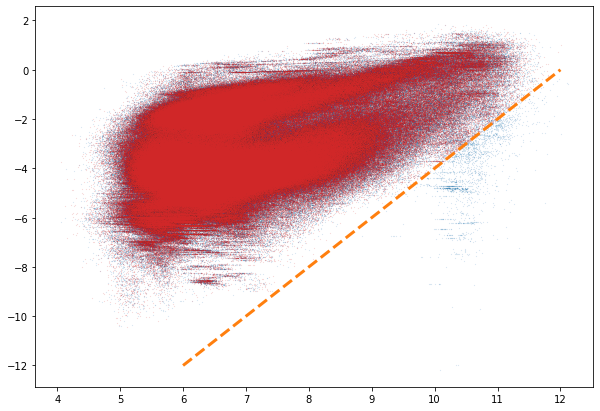

In [5]:
def f(logmass):
    return 2*logmass - 24

#get rid of that weird clump M* > 10^10 Msol and logSFR = -5
data_full_cut = data_full[(data_full['logSFRtot'] - 9) > f(data_full['logmass'])]
x = np.linspace(6,12)
plt.figure(figsize=(10,7))
plt.plot(data_full['logmass'].values[::30],data_full['logSFRtot'].values[::30]-9,'o', ms=0.1, alpha=0.6)
plt.plot(data_full_cut['logmass'].values[::30],data_full_cut['logSFRtot'].values[::30]-9,'o', c='tab:red', ms=0.1, alpha=0.6)
plt.plot(x, f(x), ls='--', lw=3)

#rewrite
data_full = data_full_cut.copy()

In [6]:
data_full['g']  = data_full['Mag_true_g_sdss_z0']
data_full['r']  = data_full['Mag_true_r_sdss_z0']
data_full['i']  = data_full['Mag_true_i_sdss_z0']
data_full['z']  = data_full['Mag_true_z_sdss_z0']

In [7]:
#data = data_full[['morphology/totalSersicIndex', 'size_true', 'Mag_true_i_sdss_z0',
#       'redshift', 'Mag_true_r_sdss_z0', 'Mag_true_g_sdss_z0',
#       'morphology/totalEllipticity',
#       'Mag_true_z_sdss_z0', 'stellar_mass','logmass']]

#from the working bijector sampling
data_full['g-r'] = data_full['g'] - data_full['r']
data_full['r-i'] = data_full['r'] - data_full['i']
data_full['i-z'] = data_full['i'] - data_full['z']

data = data_full[['redshift', 'logSFRtot', 'morphology/totalSersicIndex', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z']]

# standard scale the reference magnitude and colors
data = data.values
data[:, 2:] = (data[:, 2:] - data[:, 2:].mean(axis=0))/data[:, 2:].std(axis=0)
data = pd.DataFrame(data, columns=('redshift','logSFRtot','morphology/totalSersicIndex', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z'))

In [8]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks


#split into 100 chunks
data_list = split_dataframe(data, chunk_size=int(len(data)/1.e2))

data_subset = data.sample(n=int(len(data)/1.e2))

In [9]:
data_subset.head()

,redshift,logSFRtot,morphology/totalSersicIndex,size_true,logmass,g,r,i,z,g-r,r-i,i-z
26494195,0.839993,4.488330,-0.714435,-0.545498,-1.004448,0.553431,0.478049,0.438541,0.423773,0.710051,0.747489,0.248079
36521191,0.485630,4.640460,1.735804,-0.643484,-1.226632,1.627351,1.622923,1.608379,1.598832,0.073087,0.175045,-0.252475
12045816,0.623464,4.851593,-0.714435,-0.463523,-0.382052,0.469086,0.451461,0.444576,0.444589,0.172697,0.104796,-0.138879
36809933,0.593824,4.043162,0.185369,-0.424409,0.658648,-0.367626,-0.561368,-0.650389,-0.707697,1.789723,1.797621,1.695691
20374219,0.973160,6.221960,-0.714435,0.345915,1.052152,-1.317733,-1.231927,-1.183140,-1.142357,-0.821772,-0.878658,-0.693787


In [10]:
conditional_columns = data_subset.columns.drop(['redshift', 'logSFRtot'])
latent = Joint(Uniform([(-3,3)]), Normal(1))
means = np.array([0.5, data_subset['logSFRtot'].mean()])
stds = np.array([1/5.9, data_subset['logSFRtot'].std()]) #switched 1/6 to 1/5.9
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, n_conditions=10),
)
flow = Flow(
    data_columns = ("redshift", "logSFRtot"),
    conditional_columns = ('morphology/totalEllipticity', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z'),
    bijector = bijector,
    latent = latent,          
)

In [11]:
# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns
flow = Flow(['redshift', 'logSFRtot'], bijector, conditional_columns=data_subset.columns.drop(['redshift', 'logSFRtot']))

In [12]:
#%%time
losses = flow.train(data_subset, epochs=30, verbose=True)

Training 30 epochs 
Loss:
2.6097
-1.0612
-1.2131
-1.2472
-1.3220
-1.3382
-1.3632
-1.3868
-1.3947
-1.4094
-1.4147
-1.4451
-1.4434
-1.4624
-1.4823
-1.4866
-1.4817
-1.4905
-1.4989
-1.5119
-1.5255
-1.5256
-1.5131
-1.5267
-1.5284
-1.5153
-1.5423
-1.5499
-1.5541
-1.5463
-1.5602


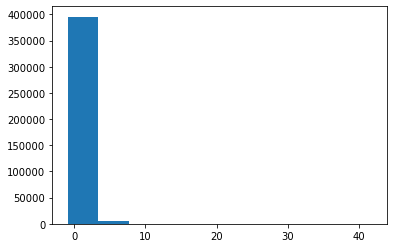

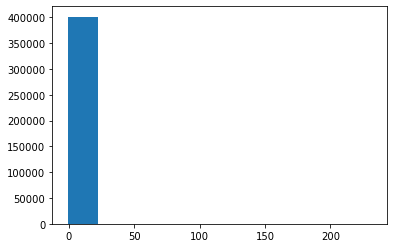

In [13]:
plt.hist(data_subset['size_true'])
plt.show()
plt.hist(data_list[0]['size_true'])
plt.show()

Text(0, 0.5, 'Training loss')

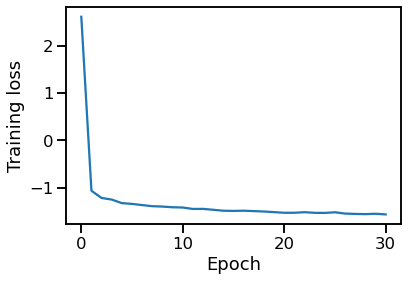

In [14]:
import seaborn as sns
sns.set_context("talk")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
#plt.savefig("TrainingLoss_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [15]:
allSamples = []
for chunk in data_list:
    samples = flow.sample(1, conditions=chunk, seed=0)
    allSamples.append(samples)

In [16]:
allSamples_DF = pd.concat(allSamples)
samples = allSamples_DF.copy()

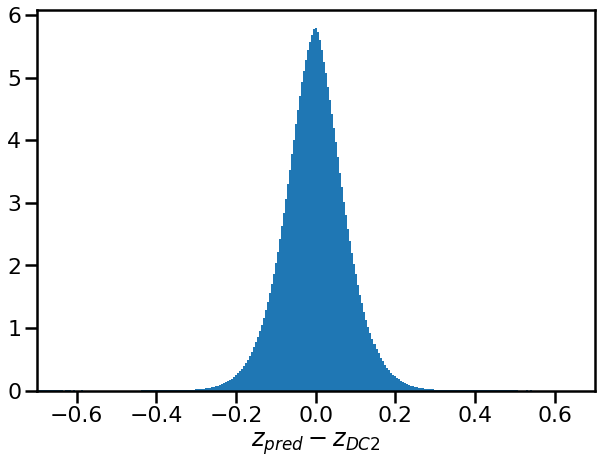

In [17]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values - data_full['redshift'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred} - z_{DC2}$");
#plt.savefig("zPred_vs_zDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

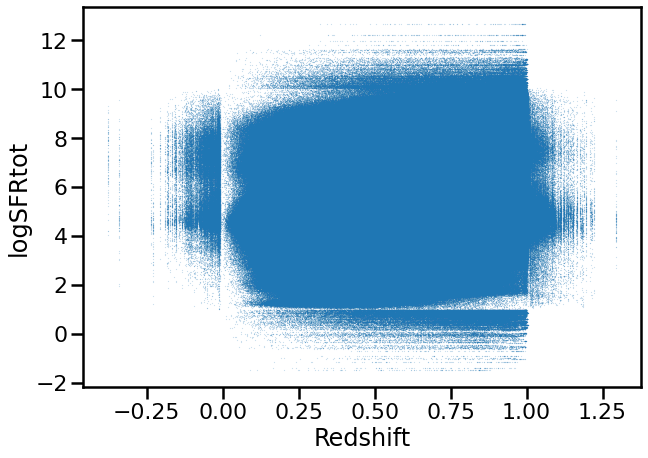

In [18]:
plt.figure(figsize=(10,7))
plt.plot(samples['redshift'], samples['logSFRtot'], 'o', ms=0.08)
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_pzFlowOnly.png",dpi=300, bbox_inches='tight')

In [19]:
len(samples[samples['redshift']>1.0])/len(samples)*100

0.44793522956745957

In [20]:
len(samples[samples['redshift']<0.0])/len(samples)*100

0.1382747582042724

In [21]:
samples_small = samples[(samples['r'] < -2.) & (samples['r'] > -3.)]
data_full_small = data[(data['r'] < -2.) & (data['r'] > -3.)]

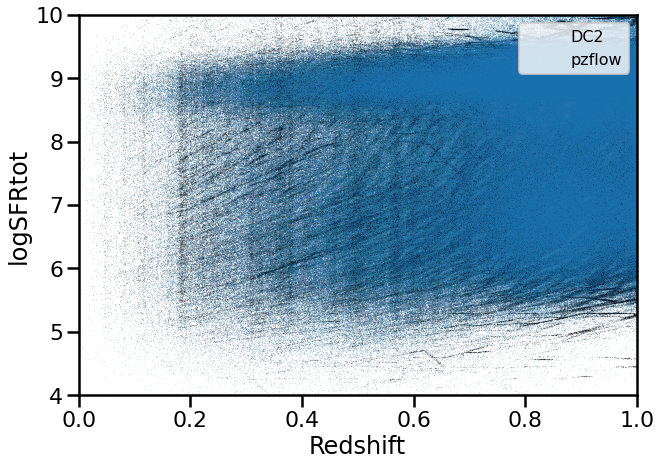

In [22]:
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
plt.legend(fontsize=16, loc='upper right')
#plt.savefig("SFR_vs_Redshift_pzFlow.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

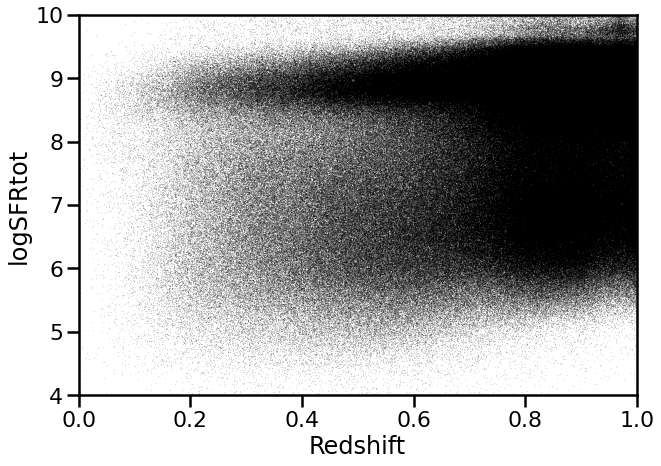

In [23]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, c='k', label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justPZFlow.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

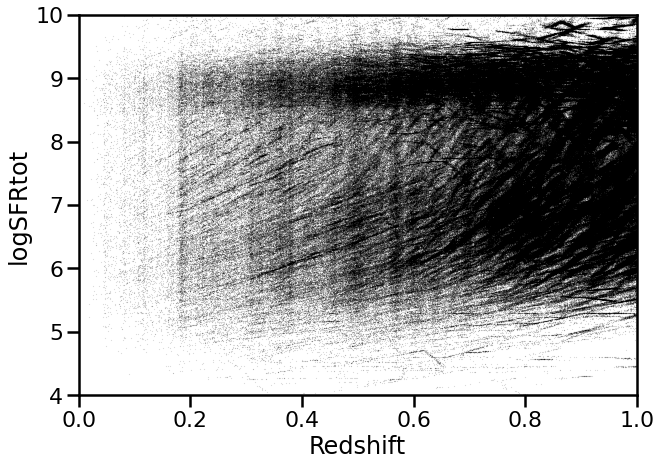

In [24]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justDC2.png",dpi=300, bbox_inches='tight')

In [44]:
data_full_save_cut

,galaxy_id,ra,dec,DC2redshift,PZflowredshift,z_bin,Mag_true_g_sdss_z0,Mag_true_r_sdss_z0,Mag_true_i_sdss_z0,Mag_true_z_sdss_z0,morphology/totalSersicIndex,size_true,morphology/totalEllipticity,stellar_mass,DC2SFRtot,PZflowSFRtot
0,9687500000,62.584977,-40.334110,0.022012,0.002570,0,-18.441294,-18.879220,-19.089607,-19.217823,1.923758,4.738221,0.334228,2.266592e+09,5.717353e+06,1.187565e+07
1,9687500001,61.398620,-41.036142,0.020724,0.081011,0,-14.991518,-15.474896,-15.756706,-15.929275,1.189470,1.385926,0.014568,2.167333e+07,1.421153e+07,1.065167e+07
2,9687500002,61.024250,-39.783545,0.020339,0.033400,0,-16.773203,-17.508795,-17.866112,-18.115364,1.499769,2.823536,0.049584,2.931496e+08,6.010335e+03,5.620870e+03
3,9687500003,61.420014,-39.964448,0.018407,0.022339,0,-15.960873,-16.709190,-17.116116,-17.517683,1.922563,3.505445,0.122115,1.110973e+08,1.670649e+08,3.097101e+08
4,9687500004,61.869596,-40.907121,0.021334,0.059985,0,-19.888374,-20.672112,-21.024305,-21.317490,3.977937,6.466721,0.075315,2.895573e+10,1.734765e+06,3.176242e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40169296,8938247215,65.981765,-39.518401,0.599504,0.624197,2,-14.264153,-14.597487,-14.744245,-14.800082,1.000000,0.136342,0.189053,1.426139e+06,1.237187e+05,1.399546e+05
40169297,8938247216,65.521496,-37.866956,0.587112,0.486960,2,-15.492109,-15.764245,-15.883749,-15.934422,1.000000,0.076466,0.147486,1.252402e+07,3.935002e+04,2.743506e+04
40169298,8938247217,66.222269,-37.662556,0.580971,0.666844,2,-12.629255,-12.940002,-13.102219,-13.160694,1.000000,0.031022,0.072827,1.185508e+05,3.638794e+04,7.239758e+04
40169299,8938247219,65.583463,-38.295553,0.599841,0.565306,2,-14.664803,-15.258070,-15.534144,-15.690044,2.020619,0.062112,0.093354,3.381268e+06,1.226774e+04,2.493794e+04


Text(0, 0.5, 'SFR (Msol/yr)')

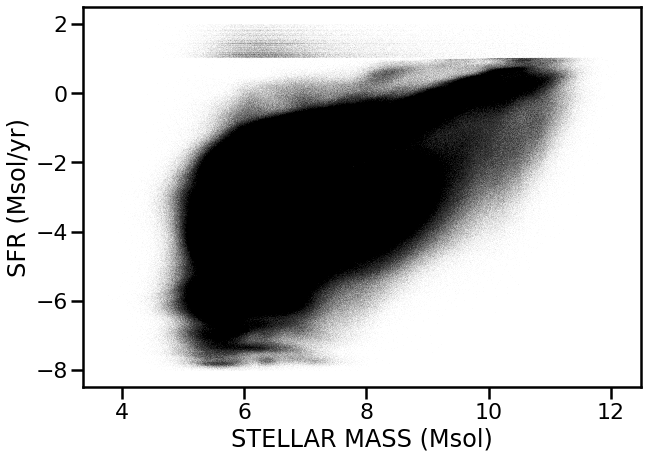

In [49]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(data_full_save_cut['stellar_mass']),np.log10(data_full_save_cut['PZflowSFRtot'])-9,'o', ms=0.01, alpha=0.6, c='k')
#plt.plot(data_full_small['logmass'],data_full_small['logSFRtot']-9,'o', ms=0.1, alpha=0.6, c='tab:red')
plt.xlabel("STELLAR MASS (Msol)")
plt.ylabel("SFR (Msol/yr)")

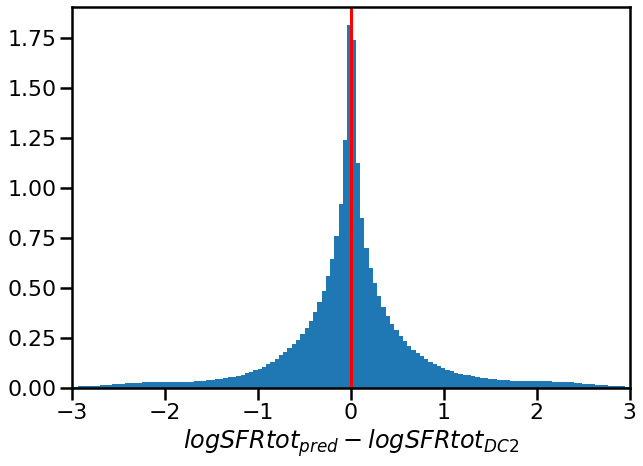

In [25]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values - data_full['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
plt.axvline(x=0, c='r')
plt.xlim((-3, 3))
plt.xlabel(r"$logSFRtot_{pred} - logSFRtot_{DC2}$");
#plt.savefig("SFRtotPred_vs_SFRtotDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

Text(0.5, 0, '$logSFRtot_{pred}$')

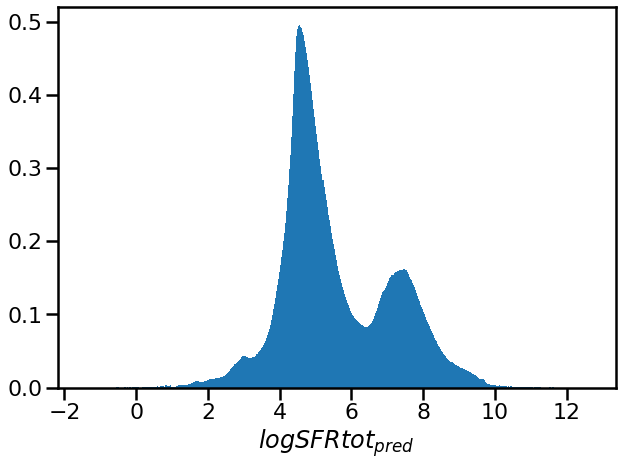

In [26]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$logSFRtot_{pred}$")
#plt.savefig("SFRtotPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

Text(0.5, 0, '$z_{pred}$')

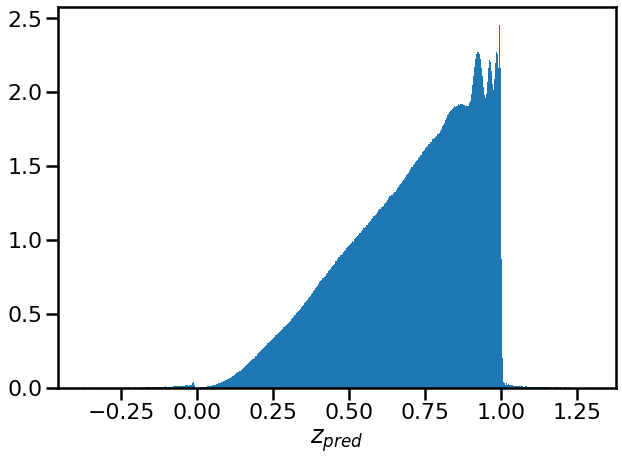

In [27]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred}$")
#plt.savefig("zPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
samples[['redshift', 'logSFRtot']].to_csv("samples_newRedshift_SFR.csv",index=False)

In [29]:
data_full['DC2redshift'] = data_full['redshift'].values
data_full['PZflowredshift'] = samples['redshift'].values

data_full['DC2SFRtot'] = 10**(data_full['logSFRtot'].values)
data_full['PZflowSFRtot'] = 10**(samples['logSFRtot'].values)

del data_full['redshift']
del data_full['logSFRtot']

In [37]:
data_full_save = data_full[['galaxy_id','ra','dec',
          'DC2redshift',
          'PZflowredshift',
          'z_bin',
          'Mag_true_g_sdss_z0',
          'Mag_true_r_sdss_z0',
          'Mag_true_i_sdss_z0',
          'Mag_true_z_sdss_z0', 
          'morphology/totalSersicIndex',
          'size_true',
          'morphology/totalEllipticity',
          'stellar_mass',
          'DC2SFRtot', 
          'PZflowSFRtot']]

In [38]:
#truncate for quality cuts
data_full_save_cut = data_full_save[(data_full_save['PZflowredshift']>=0.0) & (data_full_save['PZflowredshift']<=1.0)]

In [50]:
data_full_save_cut = data_full_save_cut[(data_full_save_cut['PZflowSFRtot'] > 1.e1) & (data_full_save_cut['PZflowSFRtot'] < 1.e10)]

In [51]:
data_full_save_cut.to_csv("./DC2_pzRedshifts_SFR_new.csv",index=False)

In [ ]:
len(data_full_save_cut)/len(data_full)

In [ ]:
samples.to_csv("./samples_conditionalRedshift.csv",index=False)

In [ ]:
#re-load data
data_full_save_cut = pd.read_csv("./DC2_pzRedshifts_SFR.csv", low_memory=True)

In [ ]:
logSFR_data = np.log10(data_full_save_cut['DC2SFRtot'].sample(n=5000))
logSFR_samples = np.log10(data_full_save_cut['PZflowSFRtot'].sample(n=5000))

In [ ]:
plt.hist(logSFR_data, range=(1, 10),bins=40,  histtype='step', label='data',lw=3)
plt.hist(logSFR_samples, range=(1, 10),bins=40,  histtype='step', label='samples',lw=3)
plt.legend()
plt.savefig("SFR_conditionalSampling.png",dpi=200, bbox_inches='tight')

In [ ]:
#truncate a few more outliers
import numpy as np 
for band in ['Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0']:
    m, b = np.polyfit(data_full_save_cut[band], data_full_save_cut['Mag_true_z_sdss_z0'], 1)
    samples_outliers = data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) > 1.3]
    samples_inliers = data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) < 1.3]
    plt.plot(samples_outliers[band], samples_outliers['Mag_true_z_sdss_z0'], 'o', ms=2)
    plt.plot(samples_inliers[band], samples_inliers['Mag_true_z_sdss_z0'], 'o', ms=1, alpha=0.1)

    data_full_save_cut =  data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) < 1.3]

In [ ]:
plt.hist(data['redshift'], range=(0, 1.0), bins=40, histtype='step', label='data')
plt.hist(samples['redshift'], range=(0, 1.0), bins=40, histtype='step', label='samples')
plt.legend()
plt.savefig("Histogram_z_allProperties_ConditionalZSFR.png",dpi=200)

In [ ]:
import seaborn as sns
import random
data_cut = data_full_save_cut[(data_full_save_cut['Mag_true_r_sdss_z0'] < -18) & ((data_full_save_cut['Mag_true_r_sdss_z0'] > -18.5))]
sns.set_context("talk")

data_cut['logstellarmass'] = np.log10(data_cut['stellar_mass'])
data_cut['logtotalSFR'] = np.log10(data_cut['PZflowSFRtot'])
data_cut['logSize'] = np.log10(data_cut['size_true'])

params = ['PZflowredshift', 'morphology/totalSersicIndex','logSize',
          'morphology/totalEllipticity','logstellarmass','logtotalSFR','ra','dec', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0']
data_cut = data_cut[params]

for i in np.arange(15):
    idx1 = random.randint(0, len(params)-1)
    idx2 = random.randint(0, len(params)-1)
    if idx1 == idx2:
        continue
    plt.figure(figsize=(10,7))
    plt.plot(data_cut[params[idx1]], data_cut[params[idx2]],'o',ms=0.05)
    plt.xlabel(params[idx1])
    plt.ylabel(params[idx2])
    plt.show()

for i in np.arange(len(params)):
    vals = data_cut[params[i]]
    vals.replace([np.inf, -np.inf], np.nan, inplace=True) #drop inf
    vals = vals[vals == vals] #drop na
    plt.figure(figsize=(10,7))
    plt.hist(vals, bins=int(1.e3))
    plt.xlabel(params[i])

In [ ]:
import seaborn as sns
import random
data_cut = data_full_save_cut[(data_full_save_cut['Mag_true_r_sdss_z0'] < -18) & ((data_full_save_cut['Mag_true_r_sdss_z0'] > -18.5))]
sns.set_context("talk")

data_cut['logstellarmass'] = np.log10(data_cut['stellar_mass'])
data_cut['logtotalSFR'] = np.log10(data_cut['PZflowSFRtot'])
data_cut['logSize'] = np.log10(data_cut['size_true'])
data_cut['g'] = data_cut['Mag_true_g_sdss_z0']
data_cut['r'] = data_cut['Mag_true_r_sdss_z0']
data_cut['i'] = data_cut['Mag_true_i_sdss_z0']
data_cut['z'] = data_cut['Mag_true_z_sdss_z0']

params = ['PZflowredshift', 'DC2redshift', 'morphology/totalSersicIndex','logSize',
          'morphology/totalEllipticity','logstellarmass','logtotalSFR','ra','dec', 'g', 'r', 'i', 'z']
data_cut = data_cut[params]

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logtotalSFR'], data_cut['z'],'o',ms=0.05)
plt.xlabel("logtotalSFR")
plt.ylabel("z")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logstellarmass'], data_cut['morphology/totalSersicIndex'],'o',ms=0.05)
plt.xlabel("logstellarmass")
plt.ylabel("morphology/totalSersicIndex")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['ra'], data_cut['morphology/totalEllipticity'],'o',ms=0.05)
plt.xlabel("ra")
plt.ylabel("morphology/totalEllipticity")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['z'], data_cut['morphology/totalSersicIndex'],'o',ms=0.05)
plt.xlabel("z")
plt.ylabel("morphology/totalSersicIndex")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['g'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("g")
plt.ylabel("logtotalSFR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logtotalSFR'], data_cut['logSize'],'o',ms=0.05)
plt.xlabel("logtotalSFR")
plt.ylabel("logSize")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['ra'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("ra")
plt.ylabel("logtotalSFR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['morphology/totalSersicIndex'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("morphology/totalSersicIndex")
plt.ylabel("logtotalSFR")
plt.show()